In [43]:
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics  import balanced_accuracy_score, roc_auc_score,  make_scorer
from sklearn.model_selection import GridSearchCV #cross validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [44]:
df = pd.read_csv('../../data/H161.csv', parse_dates = ["utc_time"])
df["utc_time"] = df["utc_time"].dt.tz_localize(None)

df.columns = ['time','phase', 'step', 'statement', 'heat_time', 'weight', 'temp', 'pressure']
df.drop(['step','statement'], axis=1, inplace=True)

/tmp/ipykernel_5362/3790334571.py:1: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../data/H161.csv', parse_dates = ["utc_time"])


In [45]:
df = df[df['phase'].str.contains ('DRYING|DISCHRG') == True]

In [46]:
df.loc[(df.weight == '????????'), 'weight'] = 0
df.loc[(df.pressure == '????????'), 'pressure'] = 0
df.loc[(df.temp == '????????'), 'temp'] = 0

In [47]:
df.dropna(inplace=True)
df.fillna(0)

,time,phase,heat_time,weight,temp,pressure
11,2020-03-23 05:19:27,DRYING,67.5,3799.5,60.3,270.9
12,2020-03-23 05:20:27,DRYING,68.5,3800.0,60.3,272.3
13,2020-03-23 05:21:27,DRYING,69.5,3799.8,60.1,290.7
14,2020-03-23 05:22:27,DRYING,70.5,3797.7,59.8,305.8
15,2020-03-23 05:23:27,DRYING,71.5,3795.8,60.0,280.7
...,...,...,...,...,...,...
1036772,2022-03-13 04:40:27,DISCHRG,0.0,164.4,16.2,761.7
1036773,2022-03-13 04:41:27,DISCHRG,0.0,164.6,15.7,761.7
1036774,2022-03-13 04:42:27,DISCHRG,0.0,164.9,15.2,761.7
1036775,2022-03-13 04:43:27,DISCHRG,0.0,164.8,14.7,761.7


In [48]:
df['temp'] = df.temp.astype(float)
df['weight'] = df.weight.astype(float)
df['pressure'] = df.pressure.astype(float)
df['heat_time'] = df.heat_time.astype(float)
df['phase'] = df.phase.astype('category')
# df.set_index('time', inplace=True)

In [49]:
n = 30  # number of points to be checked before and after

# Find local peaks
df['max_temp'] = 0
df['max_temp'] = df.iloc[argrelextrema(df.temp.values, np.greater_equal, order=n)]['temp']

In [50]:
df['ready'] = 0

In [51]:
for i in range (1, len(df['ready']-1)):
    if df.max_temp.values[i] > 0 and df.heat_time.values[i] > 10:
            while df['phase'].values[i] == 'DRYING':
                i += 1
                df.ready.values[i] = 1
df = df.drop(['max_temp'], axis=1)

In [52]:
X = df.drop('ready', axis=1).copy()
y = df['ready'].copy()

In [53]:
# X_encoded = pd.get_dummies(X, columns=['phase']).copy()
X.drop(['time', 'phase'],axis=1, inplace=True)

In [54]:
sum(y)/len(y)

0.563999778067523

## probably  half of a heating time is unnecessary???

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [56]:
sum(y_train)/len(y_train)

0.5639988163589063

In [57]:
sum(y_test)/len(y_test)

0.5640026631815156

In [58]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            gamma=0.25,
                            max_depth=7,
                            seed=42)

In [59]:
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])

/home/bazdalaz/.local/share/virtualenvs/drayers-xCtpz_mc/lib64/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/bazdalaz/.local/share/virtualenvs/drayers-xCtpz_mc/lib64/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-aucpr:0.80119
[1]	validation_0-aucpr:0.81085
[2]	validation_0-aucpr:0.81542
[3]	validation_0-aucpr:0.82202
[4]	validation_0-aucpr:0.82492
[5]	validation_0-aucpr:0.82759
[6]	validation_0-aucpr:0.83191
[7]	validation_0-aucpr:0.83382
[8]	validation_0-aucpr:0.83649
[9]	validation_0-aucpr:0.83835
[10]	validation_0-aucpr:0.83970
[11]	validation_0-aucpr:0.84065
[12]	validation_0-aucpr:0.84317
[13]	validation_0-aucpr:0.84445
[14]	validation_0-aucpr:0.84611
[15]	validation_0-aucpr:0.84953
[16]	validation_0-aucpr:0.85096
[17]	validation_0-aucpr:0.85271
[18]	validation_0-aucpr:0.85534
[19]	validation_0-aucpr:0.85800
[20]	validation_0-aucpr:0.85879
[21]	validation_0-aucpr:0.85956
[22]	validation_0-aucpr:0.86064
[23]	validation_0-aucpr:0.86081
[24]	validation_0-aucpr:0.86107
[25]	validation_0-aucpr:0.86159
[26]	validation_0-aucpr:0.86177
[27]	validation_0-aucpr:0.86430
[28]	validation_0-aucpr:0.86559
[29]	validation_0-aucpr:0.86639
[30]	validation_0-aucpr:0.86755
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.25, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

/home/bazdalaz/.local/share/virtualenvs/drayers-xCtpz_mc/lib64/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


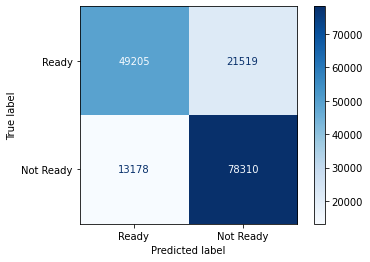

In [60]:
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      cmap='Blues',
                      display_labels=['Ready', 'Not Ready'])

In [61]:
bst = clf_xgb.get_booster()
for importance_type in ('weight','gain', 'cover', 'total_gain','total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

weight:  {'heat_time': 1932.0, 'weight': 2943.0, 'temp': 1985.0, 'pressure': 1868.0}
gain:  {'heat_time': 87.30504608154297, 'weight': 57.05839157104492, 'temp': 50.32994079589844, 'pressure': 35.70244216918945}
cover:  {'heat_time': 8495.0498046875, 'weight': 7262.32763671875, 'temp': 5509.65673828125, 'pressure': 5899.12744140625}
total_gain:  {'heat_time': 168673.34375, 'weight': 167922.84375, 'temp': 99904.9296875, 'pressure': 66692.1640625}
total_cover:  {'heat_time': 16412437.0, 'weight': 21373030.0, 'temp': 10936669.0, 'pressure': 11019570.0}


In [62]:
node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}

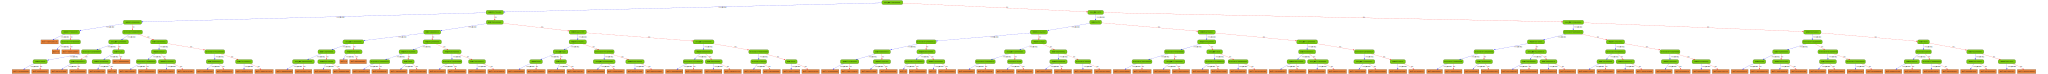

In [63]:
xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)